# **Variational Autoencoder**

## **Initialization**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.functional import Tensor
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

PATH = "/content/gdrive/MyDrive/ex3_313581803_314882861/Q3.3"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = 28*28
INTERMEDIATE = 600
LATENT_SIZE = 50
BATCH_SIZE = 64

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Load Data**
Get mnist-fashion data from https://github.com/zalandoresearch/fashion-mnist.

In [ ]:
torch.manual_seed(42)

train_set = datasets.FashionMNIST(
    root = f'{PATH}/Data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                         
    ])
)
test_set = datasets.FashionMNIST(
    root = f'{PATH}/Data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                
    ])
)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

train_set_size = train_set.data.shape[0]

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/ex3_313581803_314882861/Q3.3/Data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/gdrive/MyDrive/ex3_313581803_314882861/Q3.3/Data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/ex3_313581803_314882861/Q3.3/Data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/ex3_313581803_314882861/Q3.3/Data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/ex3_313581803_314882861/Q3.3/Data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/gdrive/MyDrive/ex3_313581803_314882861/Q3.3/Data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/gdrive/MyDrive/ex3_313581803_314882861/Q3.3/Data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/ex3_313581803_314882861/Q3.3/Data/FashionMNIST/FashionMNIST/raw



### **Network Architecture**

Implement Variational Autoencoder for Fashion-Mnis

In [ ]:
class VAE(nn.Module):
    def __init__(self):
      super(VAE, self).__init__()
      self.encoder = nn.Sequential(
          nn.Linear(INPUT_SIZE, INTERMEDIATE),
          nn.BatchNorm1d(INTERMEDIATE),
          nn.Softplus(),
          nn.Linear(INTERMEDIATE, INTERMEDIATE),
          nn.BatchNorm1d(INTERMEDIATE),
          nn.Softplus()
        )
      self.decoder = nn.Sequential(
          nn.Linear(LATENT_SIZE, INTERMEDIATE),
          nn.BatchNorm1d(INTERMEDIATE),
          nn.Softplus(),
          nn.Linear(INTERMEDIATE, INTERMEDIATE),
          nn.BatchNorm1d(INTERMEDIATE),
          nn.Softplus(),
          nn.Linear(INTERMEDIATE, INPUT_SIZE),
          nn.Sigmoid()
        )
      self.mean_layer = nn.Linear(INTERMEDIATE, LATENT_SIZE)
      self.std_layer = nn.Linear(INTERMEDIATE, LATENT_SIZE)
      self.reconstraction_criterion = nn.BCELoss(reduction="sum")

    def sampling(self, mean, std, size):
      epsilon = torch.normal(mean=torch.zeros(size,1), std=torch.ones(size,1)).to(DEVICE)
      return mean + epsilon * std

    def forward(self, input):
      encoded = self.encoder(input.view(input.shape[0], -1))
      mean, std = self.mean_layer(encoded), self.std_layer(encoded)
      z = self.sampling(mean, std, input.shape[0])
      return mean, std, self.decoder(z), z

    def loss(self, x, x_hat, mean, std):
      distribution_loss = - 0.5 * (1 + torch.log(std**2) - mean**2 - std**2).sum()
      reconstruction_loss = self.reconstraction_criterion(x_hat, x.view(x.shape[0], -1))
      return (reconstruction_loss + distribution_loss)

## **Train Autoencoder Model**

In [ ]:
def fit(model, train_loader, optimizer, file_name, epochs=30, save_model=False):
    results = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        model.train()
        for (x, _) in train_loader:
            x = x.to(DEVICE)
            mean, std, x_hat, _ = model(x)
            loss = model.loss(x, x_hat, mean, std)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss
        results.append(float(total_loss) / train_set_size)
        if (epoch + 1) % 5 == 0:
            print(f"Epoch: {epoch}, loss: {results[-1]}.")
            show_images(model, x[-1])
    if save_model:
        torch.save(model.state_dict(), f"{PATH}/Models/{file_name}.pt")
    generate_plots(results, file_name)
  

def show_images(model, sample):
    with torch.no_grad():
        model.eval()
        reconstruct_sample = model(sample)[2]
        f, axarr = plt.subplots(1,2, figsize=(12, 8))
        axarr[0].imshow(sample.clone().cpu().detach().numpy().reshape(28, 28), vmin=0, vmax=1, cmap='gray')
        axarr[1].imshow(reconstruct_sample.clone().cpu().detach().numpy().reshape(28,28), vmin=0, vmax=1, cmap='gray')
        axarr[0].axis('off')
        axarr[1].axis('off')
        plt.show()


def generate_plots(results, file_name):
      if not os.path.exists(f"{PATH}/Results"):
          os.mkdir(f"{PATH}/Results")
      plt.xlabel("Epochs")
      plt.ylabel("loss")
      plt.plot(np.arange(len(results)), np.array(results), label='Loss', linewidth=5.0)
      plt.title('Loss per epoch')
      plt.legend()
      plt.grid()
      plt.savefig(f'{PATH}/Results/{file_name}.png', bbox_inches='tight')
      plt.close()


Epoch: 4, loss: 228.2402.


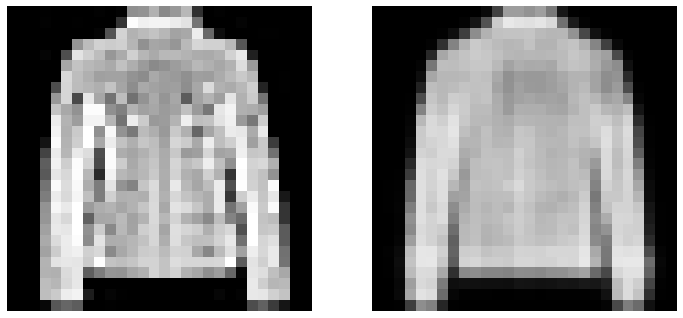

Epoch: 9, loss: 220.85045.


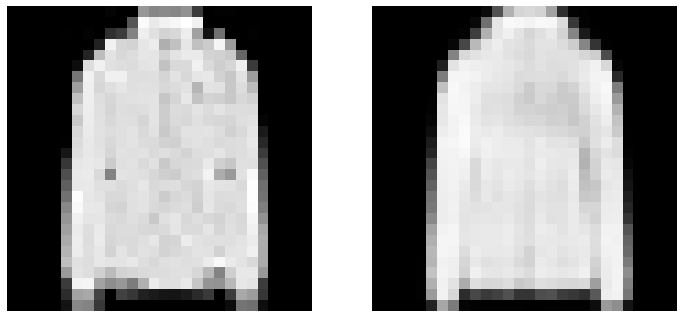

Epoch: 14, loss: 217.29698333333334.


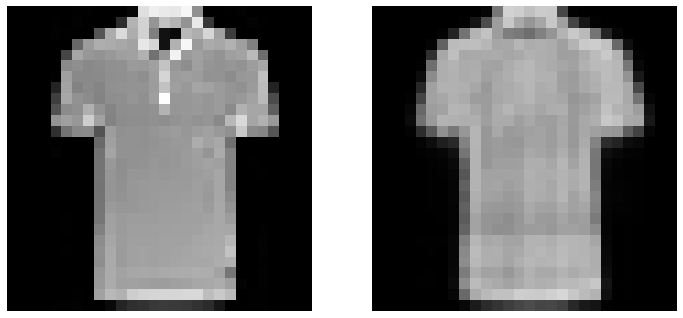

Epoch: 19, loss: 215.22873333333334.


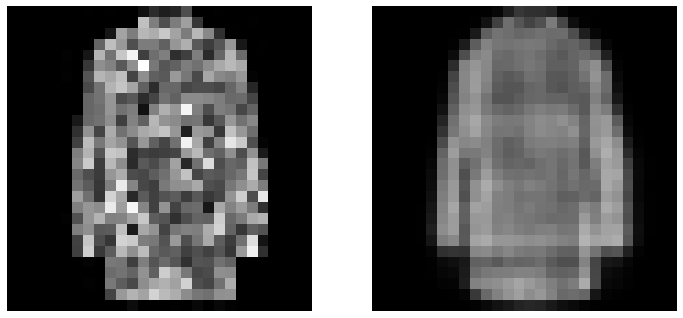

Epoch: 24, loss: 213.6784.


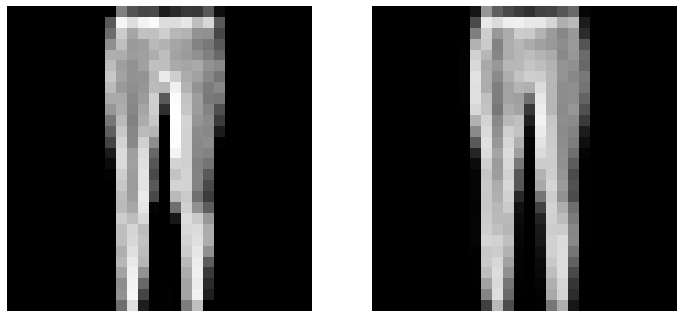

Epoch: 29, loss: 212.52936666666668.


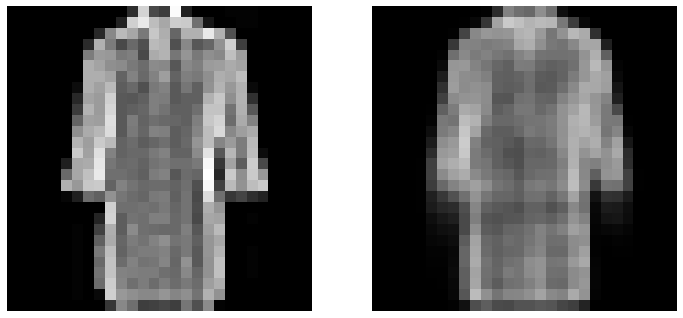

In [ ]:
if not os.path.exists(f"{PATH}/Models"):
    os.mkdir(f"{PATH}/Models")

auto_encoder_file_name = "VAE_test" 
model = VAE().to(DEVICE)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0003, momentum=0.1, weight_decay=0.001)
fit(model, train_loader, optimizer, file_name=auto_encoder_file_name, save_model=True)

## **Train SVM Model**

In [ ]:
def get_balanced_samples(labels, benchmark):
  idx = (np.arange(len(labels)))
  train_idx = []
  np.random.shuffle(idx)
  for label in range(10):
    counter = 0
    for i in idx:
      if counter == benchmark / 10:
        break
      if labels[i] == label:
        train_idx.append(i)
        counter += 1
  mask = np.ones(len(idx), dtype=bool)
  mask[train_idx] = False
  test = idx[mask]
  np.random.shuffle(train_idx)
  return train_idx, idx[mask]


def predict_svm(svm_model, auto_encoder_model, data, benchmark, file_name=None, train_mode=False):
  torch.manual_seed(42)
  samples, labels = data.data, data.targets
  samples = samples.view(-1, 1, 28, 28) / 255.0
  latent = auto_encoder_model(samples.to(DEVICE))[-1].cpu().detach().numpy()
  labels = np.array(labels)
  if train_mode:
      train_idx, test_idx = get_balanced_samples(labels, bm)
      svm_model.fit(latent[train_idx], labels[train_idx])
      with open(f"{PATH}/Models/{file_name}_{benchmark}.p", 'wb') as f:
        pickle.dump(svm_model, f)
  else:
      test_idx = (np.arange(len(labels)))
      np.random.shuffle(test_idx)
  pred = np.array(svm_model.predict(latent[test_idx]))
  accuracy = (pred == labels[test_idx]).sum() / len(test_idx)
  print(f"Number of labeled samples: {benchmark}. Accuracy: {accuracy}.")


In [ ]:
benchmarks = [100, 600, 1000, 3000] 

if not os.path.exists(f"{PATH}/Models"):
    os.mkdir(f"{PATH}/Models")

auto_encoder_file_name = "VAE_test" 
auto_encoder_model = VAE().to(DEVICE)
auto_encoder_model.load_state_dict(torch.load(f"{PATH}/Models/{auto_encoder_file_name}.pt"))

svm_file_name = "svm_test"
svm_model = SVC(kernel="linear")
for bm in benchmarks:
  predict_svm(svm_model, auto_encoder_model, test_set, bm, svm_file_name, train_mode=True)

Number of labeled samples: 100. Accuracy: 0.7053535353535354.
Number of labeled samples: 600. Accuracy: 0.7909574468085107.
Number of labeled samples: 1000. Accuracy: 0.8102222222222222.
Number of labeled samples: 3000. Accuracy: 0.8301428571428572.


## **Evaluation**

In [ ]:
benchmarks = [100, 600, 1000, 3000] 

auto_encoder_file_name = "VAE_trained"
auto_encoder_model = VAE().to(DEVICE)
auto_encoder_model.load_state_dict(torch.load(f"{PATH}/Models/{auto_encoder_file_name}.pt", map_location=DEVICE))

svm_file_name = "svm_trained"
for bm in benchmarks:
  with open(f"{PATH}/Models/{svm_file_name}_{bm}.p", 'rb') as f:
      svm_model = pickle.load(f)
      predict_svm(svm_model, auto_encoder_model, test_set, bm)

Number of labeled samples: 100. Accuracy: 0.7039.
Number of labeled samples: 600. Accuracy: 0.7898.
Number of labeled samples: 1000. Accuracy: 0.8106.
Number of labeled samples: 3000. Accuracy: 0.8324.
